In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Imports
import os, sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import json
import glob
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
REPO_NAME = "KANs"
GITHUB_USER = "neelbaiyar"

REPO_DIR = f"/content/{REPO_NAME}"

# Clone repo if missing
if not os.path.isdir(REPO_DIR):
    print(f"Cloning {REPO_NAME}...")
    !git clone https://github.com/{GITHUB_USER}/{REPO_NAME}.git
else:
    print(f"{REPO_NAME} already exists. Pulling latest changes...")
    %cd {REPO_DIR}
    !git pull
# Move into repo
%cd {REPO_DIR}
print("Current working directory:", os.getcwd())


Cloning KANs...
Cloning into 'KANs'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 75 (delta 36), reused 40 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (75/75), 15.80 KiB | 15.80 MiB/s, done.
Resolving deltas: 100% (36/36), done.
/content/KANs
Current working directory: /content/KANs


In [ ]:
!git fetch origin
!git reset --hard origin/main

HEAD is now at f7e8061 Added activation functions


In [ ]:
for folder in ["src", "notebooks", "results"]:
    if not os.path.isdir(folder):
        os.makedirs(folder)
        print(f"Created folder: {folder}")
    else:
        print(f"Folder already exists: {folder}")

Folder already exists: src
Folder already exists: notebooks
Folder already exists: results


In [ ]:
SRC_PATH = os.path.join(os.getcwd(), "src")
if SRC_PATH not in sys.path:
    sys.path.append(SRC_PATH)

print("PYTHONPATH updated. src is now importable.")

PYTHONPATH updated. src is now importable.


In [ ]:
import importlib, train_loop
importlib.reload(train_loop)
from train_loop import train_one_activation

In [ ]:
import importlib, data_loader
importlib.reload(data_loader)
from data_loader import get_mnist_loaders, get_cifar10_loaders

In [ ]:
from activations import ACTIVATION_FACTORIES
from models import MLP
from data_loader import get_mnist_loaders, get_cifar10_loaders
from train_loop import train_one_activation
from kan_model import KAN

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
list(ACTIVATION_FACTORIES.keys())

['relu',
 'leakyrelu',
 'gelu',
 'silu',
 'tanh',
 'sigmoid',
 'softplus',
 'mish',
 'sawtooth',
 'sinlinear',
 'identity',
 'abs',
 'softabs',
 'sine',
 'sinc',
 'sinh',
 'sinelu',
 'nand',
 'nor',
 'xor',
 'smoothxor',
 'cubicsigm',
 'squarewav',
 'sawtoothramp',
 'perlin',
 'weierstrass',
 'cantor']

In [ ]:
# CONFIG — THIS IS ALL YOU EVER EDIT
USE_KAN = True

BASE_ACTIVATIONS = list(ACTIVATION_FACTORIES.keys())
#BASE_ACTIVATIONS.remove("nand")
#BASE_ACTIVATIONS.remove("nor")
# Example override if you ever want:
#BASE_ACTIVATIONS = ["relu", "gelu"] #comment out this line if you want everything in ACTIVATION_FACTORIES
# BASE_ACTIVATIONS = ["xor"]


EPOCHS_BY_DATASET = { #edit epochs/dataset
    "mnist": 20,
    "cifar10": 50
}

BATCH_SIZE_BY_DATASET = {
    "mnist": 128,
    "cifar10": 128,
}

DATASETS = {
    "mnist": get_mnist_loaders,
    "cifar10": get_cifar10_loaders
}

ALL_RESULTS = {}

for dataset_name, loader_fn in DATASETS.items():
    print(f"\n========================")
    print(f"Running dataset: {dataset_name.upper()}")
    print(f"========================")

    epochs = EPOCHS_BY_DATASET[dataset_name]
    batch_size = BATCH_SIZE_BY_DATASET[dataset_name]

    print(f"Using {epochs} epochs | Batch size {batch_size}")

    train_loader, test_loader, input_dim, num_classes = loader_fn(
        batch_size=batch_size,
        small=True
    )

    epochs = EPOCHS_BY_DATASET[dataset_name]
    print(f"Using {epochs} epochs for {dataset_name}")

    results = {}

    # Regular MLP activations
    for act in BASE_ACTIVATIONS:
        print(f"\n=== Activation: {act} on {dataset_name} ===")
        results[act] = train_one_activation(
            activation_name=act,
            train_loader=train_loader,
            test_loader=test_loader,
            input_dim=input_dim,
            output_dim=num_classes,
            hidden_dims=[256, 128],
            epochs=epochs,
            device=device
        )

    # KAN
    if USE_KAN:
        print(f"\n=== KAN on {dataset_name} ===")
        results["KAN"] = train_one_activation(
            activation_name="KAN",
            train_loader=train_loader,
            test_loader=test_loader,
            input_dim=input_dim,
            output_dim=num_classes,
            hidden_dims=[256, 128],
            epochs=epochs,
            device=device
        )

    ALL_RESULTS[dataset_name] = results



Running dataset: MNIST
Using 20 epochs | Batch size 128


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 508kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.72MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 15.0MB/s]


Using 20 epochs for mnist

=== Activation: relu on mnist ===
[relu] Epoch 1/20 | Train 0.8652 | Val 0.3781 | ValAcc 0.8830 | Time 1.65s
[relu] Epoch 2/20 | Train 0.3111 | Val 0.2956 | ValAcc 0.9135 | Time 1.09s
[relu] Epoch 3/20 | Train 0.2425 | Val 0.2586 | ValAcc 0.9245 | Time 1.11s
[relu] Epoch 4/20 | Train 0.1929 | Val 0.2255 | ValAcc 0.9270 | Time 1.10s
[relu] Epoch 5/20 | Train 0.1590 | Val 0.2294 | ValAcc 0.9230 | Time 1.09s
[relu] Epoch 6/20 | Train 0.1269 | Val 0.1930 | ValAcc 0.9405 | Time 1.09s
[relu] Epoch 7/20 | Train 0.1094 | Val 0.1876 | ValAcc 0.9395 | Time 1.07s
[relu] Epoch 8/20 | Train 0.0855 | Val 0.1761 | ValAcc 0.9415 | Time 1.35s
[relu] Epoch 9/20 | Train 0.0721 | Val 0.1735 | ValAcc 0.9440 | Time 1.57s
[relu] Epoch 10/20 | Train 0.0599 | Val 0.1709 | ValAcc 0.9465 | Time 1.30s
[relu] Epoch 11/20 | Train 0.0474 | Val 0.1598 | ValAcc 0.9480 | Time 1.09s
[relu] Epoch 12/20 | Train 0.0364 | Val 0.1559 | ValAcc 0.9490 | Time 1.09s
[relu] Epoch 13/20 | Train 0.0331 | 

100%|██████████| 170M/170M [00:03<00:00, 42.9MB/s]


Using 50 epochs for cifar10

=== Activation: relu on cifar10 ===
[relu] Epoch 1/50 | Train 1.8445 | Val 1.6628 | ValAcc 0.4215 | Time 2.41s
[relu] Epoch 2/50 | Train 1.5927 | Val 1.6074 | ValAcc 0.4245 | Time 2.08s
[relu] Epoch 3/50 | Train 1.4529 | Val 1.6013 | ValAcc 0.4440 | Time 2.06s
[relu] Epoch 4/50 | Train 1.3411 | Val 1.5801 | ValAcc 0.4505 | Time 2.07s
[relu] Epoch 5/50 | Train 1.2326 | Val 1.6102 | ValAcc 0.4390 | Time 2.71s
[relu] Epoch 6/50 | Train 1.1243 | Val 1.6273 | ValAcc 0.4535 | Time 2.24s
[relu] Epoch 7/50 | Train 1.0352 | Val 1.6583 | ValAcc 0.4580 | Time 2.06s
[relu] Epoch 8/50 | Train 0.9325 | Val 1.7207 | ValAcc 0.4445 | Time 2.06s
⏹ Early stopping at epoch 9

=== Activation: leakyrelu on cifar10 ===
[leakyrelu] Epoch 1/50 | Train 1.8430 | Val 1.7042 | ValAcc 0.3955 | Time 2.98s
[leakyrelu] Epoch 2/50 | Train 1.6007 | Val 1.6232 | ValAcc 0.4230 | Time 2.05s
[leakyrelu] Epoch 3/50 | Train 1.4883 | Val 1.5930 | ValAcc 0.4325 | Time 2.15s
[leakyrelu] Epoch 4/50 | 

In [ ]:
timestamp = time.strftime("%m.%d.%Y_%H.%M.%S")

LOCAL_RESULTS_DIR = "results"
os.makedirs(LOCAL_RESULTS_DIR, exist_ok=True)

local_path = f"{LOCAL_RESULTS_DIR}/full_results_{timestamp}.json"

with open(local_path, "w") as f:
    json.dump(ALL_RESULTS, f, indent=2)

print(f"Full results saved to: {local_path}")


Full results saved to: results/full_results_12.11.2025_23.37.29.json


In [ ]:
# helper
def extract_metric(dataset_results, metric):
    labels = []
    values = []
    for act, data in dataset_results.items():
        labels.append(act)
        values.append(data[metric])
    return labels, values

In [ ]:
latest_file = sorted(glob.glob("results/full_results*.json"))[-1]

with open(latest_file, "r") as f:
    data = json.load(f)

print("Loaded:", os.path.basename(latest_file))

Loaded: full_results_12.11.2025_23.37.29.json


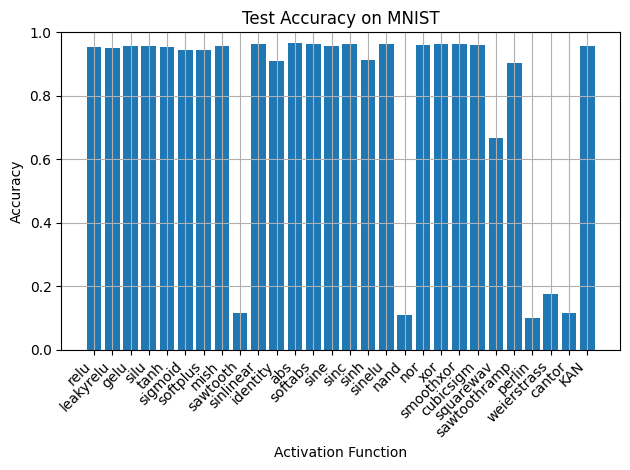

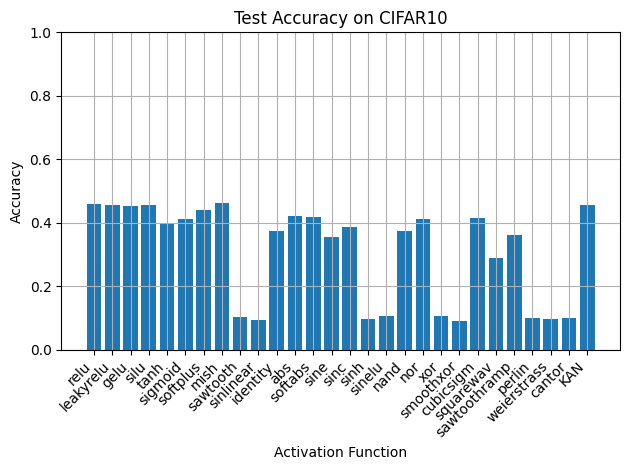

In [ ]:
# accuracy plots
for dataset_name, dataset_results in ALL_RESULTS.items():
    labels, values = extract_metric(dataset_results, "test_accuracy")

    plt.figure()
    plt.bar(labels, values)
    plt.title(f"Test Accuracy on {dataset_name.upper()}")
    plt.xlabel("Activation Function")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.grid(True)
    plt.show()

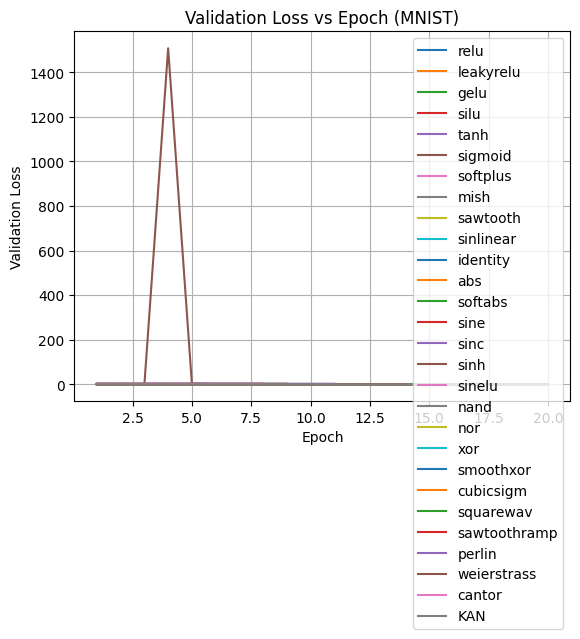

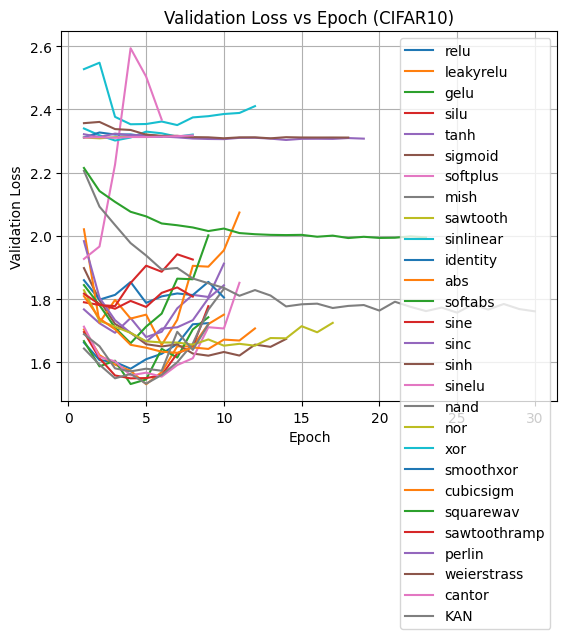

In [ ]:
for dataset in data:
    plt.figure()

    for act in data[dataset]:
        val_losses = data[dataset][act]["val_loss"]
        epochs = list(range(1, len(val_losses) + 1))
        plt.plot(epochs, val_losses, label=act)

    plt.xlabel("Epoch")
    plt.ylabel("Validation Loss")
    plt.title(f"Validation Loss vs Epoch ({dataset.upper()})")
    plt.legend()
    plt.grid(True)
    plt.show()

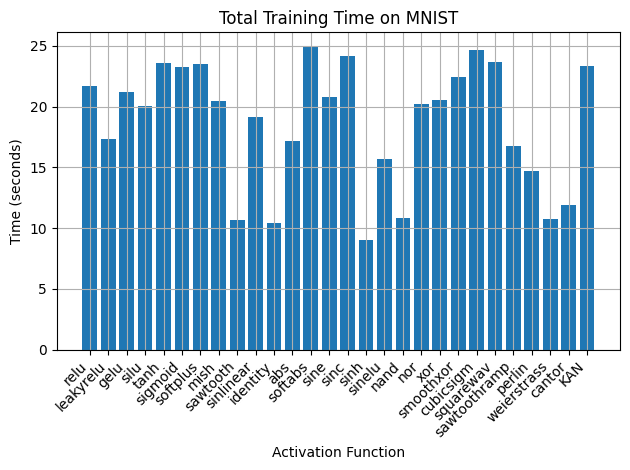

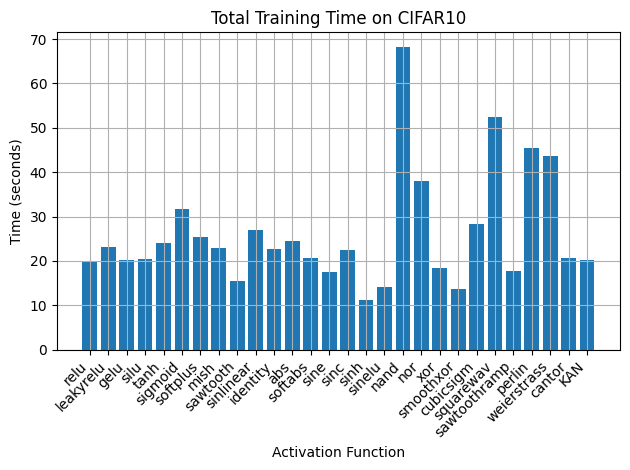

In [ ]:
# train time plots
for dataset_name, dataset_results in ALL_RESULTS.items():
    labels, values = extract_metric(dataset_results, "train_time_total")

    plt.figure()
    plt.bar(labels, values)
    plt.title(f"Total Training Time on {dataset_name.upper()}")
    plt.xlabel("Activation Function")
    plt.ylabel("Time (seconds)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.grid(True)
    plt.show()

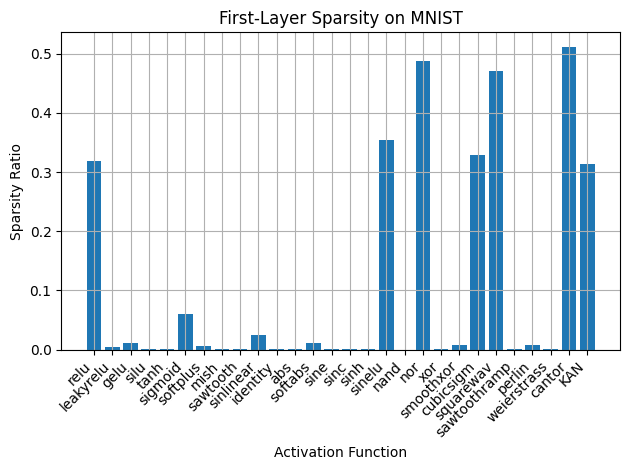

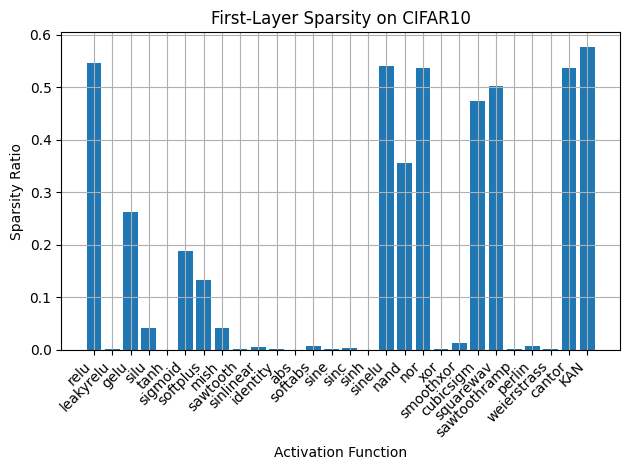

In [ ]:
# sparsity plots
for dataset_name, dataset_results in ALL_RESULTS.items():
    labels, values = extract_metric(dataset_results, "sparsity_first_hidden")

    plt.figure()
    plt.bar(labels, values)
    plt.title(f"First-Layer Sparsity on {dataset_name.upper()}")
    plt.xlabel("Activation Function")
    plt.ylabel("Sparsity Ratio")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.grid(True)
    plt.show()

In [ ]:
rows = []
for dataset in data:
    for act in data[dataset]:
        rows.append({
            "Dataset": dataset.upper(),
            "Activation": act,
            "Test Accuracy": data[dataset][act]["test_accuracy"]
        })

accuracy_df = pd.DataFrame(rows)
accuracy_df

,Dataset,Activation,Test Accuracy
0,MNIST,relu,0.9530
1,MNIST,leakyrelu,0.9520
2,MNIST,gelu,0.9560
3,MNIST,silu,0.9560
4,MNIST,tanh,0.9545
5,MNIST,sigmoid,0.9440
6,MNIST,softplus,0.9435
7,MNIST,mish,0.9570
8,MNIST,sawtooth,0.1145
9,MNIST,sinlinear,0.9620


In [ ]:
# Load latest results
latest_file = sorted(glob.glob("results/full_results*.json"))[-1]
with open(latest_file, "r") as f:
    data = json.load(f)

rows = []

for dataset in data:
    for act in data[dataset]:
        best_val = min(data[dataset][act]["val_loss"])
        final_val = data[dataset][act]["val_loss"][-1]

        rows.append({
            "Dataset": dataset.upper(),
            "Activation": act,
            "Best Val Loss": round(best_val, 4),
            "Final Val Loss": round(final_val, 4)
        })

val_loss_table = pd.DataFrame(rows)
val_loss_table

,Dataset,Activation,Best Val Loss,Final Val Loss
0,MNIST,relu,0.1542,0.1641
1,MNIST,leakyrelu,0.1636,0.1845
2,MNIST,gelu,0.1626,0.1731
3,MNIST,silu,0.1645,0.1733
4,MNIST,tanh,0.1639,0.1647
5,MNIST,sigmoid,0.1783,0.1783
6,MNIST,softplus,0.1894,0.2064
7,MNIST,mish,0.1583,0.1687
8,MNIST,sawtooth,2.3069,2.3097
9,MNIST,sinlinear,0.1406,0.1441


In [ ]:
rows = []
for dataset in data:
    for act in data[dataset]:
        rows.append({
            "Dataset": dataset.upper(),
            "Activation": act,
            "Training Time (sec)": round(data[dataset][act]["train_time_total"], 2)
        })

time_df = pd.DataFrame(rows)
time_df


,Dataset,Activation,Training Time (sec)
0,MNIST,relu,21.66
1,MNIST,leakyrelu,17.30
2,MNIST,gelu,21.17
3,MNIST,silu,20.09
4,MNIST,tanh,23.60
5,MNIST,sigmoid,23.30
6,MNIST,softplus,23.49
7,MNIST,mish,20.51
8,MNIST,sawtooth,10.64
9,MNIST,sinlinear,19.15


In [ ]:
rows = []
for dataset in data:
    for act in data[dataset]:
        rows.append({
            "Dataset": dataset.upper(),
            "Activation": act,
            "Sparsity (First Hidden Layer)": round(data[dataset][act]["sparsity_first_hidden"], 4)
        })

sparsity_df = pd.DataFrame(rows)
sparsity_df

,Dataset,Activation,Sparsity (First Hidden Layer)
0,MNIST,relu,0.3182
1,MNIST,leakyrelu,0.0049
2,MNIST,gelu,0.0106
3,MNIST,silu,0.0016
4,MNIST,tanh,0.0009
5,MNIST,sigmoid,0.0595
6,MNIST,softplus,0.0059
7,MNIST,mish,0.0014
8,MNIST,sawtooth,0.0010
9,MNIST,sinlinear,0.0253


In [ ]:
accuracy_df.to_csv("results/accuracy_table.csv", index=False)
time_df.to_csv("results/training_time_table.csv", index=False)
sparsity_df.to_csv("results/sparsity_table.csv", index=False)
val_loss_table.to_csv("results/val_loss_table.csv", index=False)

print("Tables saved to /results/")


Tables saved to /results/


In [ ]:
!nvidia-smi

Thu Dec 11 23:37:31 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   59C    P0             29W /   70W |     186MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----